# LBA Cloud Tracking Validation

This notebook validates the CloudTracker output for the LBA deep convection case.
We check:
1. Basic data integrity and track statistics
2. Cloud lifecycles (birth, death, duration)
3. Cloud tracking continuity (are tracks connecting properly?)
4. Size and vertical extent distributions
5. Merge/split behaviour
6. Visualisation of example tracked clouds

In [4]:
# Configuration
NC_FILE = "../../cloud_results_lba.nc"

# LBA simulation parameters
DX = 200.0  # m, horizontal grid spacing
DY = 200.0  # m
DT = 180.0  # s, timestep interval

# Filtering thresholds
MIN_LIFETIME_STEPS = 1    # Minimum lifetime in timesteps
MIN_MAX_SIZE = 10         # Minimum max size (voxels) to be considered

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
from matplotlib.colors import LogNorm

## 1. Load Data and Basic Statistics

In [5]:
# Load the tracking output
ds = xr.open_dataset(NC_FILE)

print("=" * 60)
print("LBA CLOUD TRACKING OUTPUT SUMMARY")
print("=" * 60)

# Basic dimensions
n_tracks = ds.sizes['track']
n_times = ds.sizes['time']
n_levels = ds.sizes['level']

print(f"\nDimensions:")
print(f"  Max tracks allocated: {n_tracks}")
print(f"  Timesteps: {n_times}")
print(f"  Vertical levels: {n_levels}")

# Height coordinate
heights = ds.height.values
print(f"\nVertical grid:")
print(f"  Height range: {heights.min():.0f} - {heights.max():.0f} m")
print(f"  dz (first 5 levels): {np.diff(heights[:6])}")

LBA CLOUD TRACKING OUTPUT SUMMARY

Dimensions:
  Max tracks allocated: 100000
  Timesteps: 15
  Vertical levels: 211

Vertical grid:
  Height range: -25 - 22900 m
  dz (first 5 levels): [50.000088 50.0001   50.0002   50.00042  50.00084 ]


In [6]:
# Count valid vs tainted tracks
valid_track = ds.valid_track.values
n_valid = np.sum(valid_track == 1)
n_tainted = np.sum(valid_track == 0)

# Count tracks that actually have data (size > 0 at some point)
size = ds['size'].values
has_data = np.any(np.isfinite(size) & (size > 0), axis=1)
n_with_data = np.sum(has_data)

print(f"\nTrack counts:")
print(f"  Tracks with data: {n_with_data}")
print(f"  Valid (complete lifecycle): {n_valid}")
print(f"  Tainted (partial lifecycle): {n_tainted}")
print(f"  Fraction valid: {100*n_valid/max(1,n_with_data):.1f}%")

# Note: In short simulations, most clouds are tainted (present at start or end)
if n_times < 10:
    print(f"\n⚠ Note: Only {n_times} timesteps - most clouds will be tainted")


Track counts:
  Tracks with data: 965
  Valid (complete lifecycle): 99729
  Tainted (partial lifecycle): 271
  Fraction valid: 10334.6%


## 2. Cloud Population Over Time

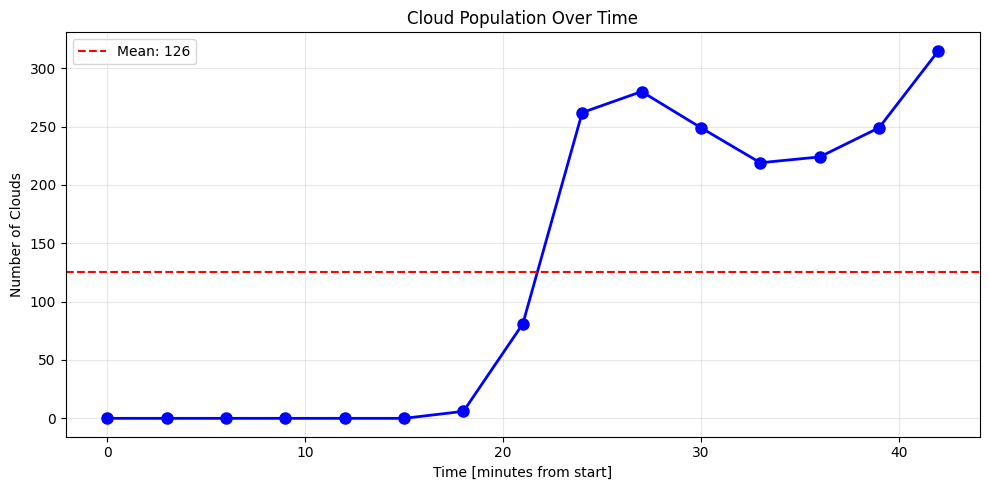

Cloud count: min=0, max=315, mean=125.7


In [7]:
# Count clouds at each timestep
clouds_per_timestep = []
for t in range(n_times):
    # Cloud exists if size > 0 and finite
    mask = np.isfinite(size[:, t]) & (size[:, t] > 0)
    clouds_per_timestep.append(np.sum(mask))

clouds_per_timestep = np.array(clouds_per_timestep)
time_minutes = np.arange(n_times) * DT / 60

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_minutes, clouds_per_timestep, 'b-o', linewidth=2, markersize=8)
ax.set_xlabel('Time [minutes from start]')
ax.set_ylabel('Number of Clouds')
ax.set_title('Cloud Population Over Time')
ax.grid(True, alpha=0.3)

# Add statistics
ax.axhline(clouds_per_timestep.mean(), color='r', linestyle='--', 
           label=f'Mean: {clouds_per_timestep.mean():.0f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Cloud count: min={clouds_per_timestep.min()}, max={clouds_per_timestep.max()}, mean={clouds_per_timestep.mean():.1f}")

## 3. Cloud Lifetime Analysis

Are clouds being tracked across multiple timesteps?

In [8]:
# Calculate lifetime for each track
lifetimes = []
max_sizes = []
track_indices = []

for i in range(n_tracks):
    size_row = size[i, :]
    valid_times = np.isfinite(size_row) & (size_row > 0)
    lifetime = np.sum(valid_times)
    
    if lifetime > 0:
        lifetimes.append(lifetime)
        max_sizes.append(np.nanmax(size_row))
        track_indices.append(i)

lifetimes = np.array(lifetimes)
max_sizes = np.array(max_sizes)
track_indices = np.array(track_indices)

print(f"Tracks with lifetime > 0: {len(lifetimes)}")
print(f"\nLifetime distribution (timesteps):")
print(f"  Min: {lifetimes.min()}")
print(f"  Max: {lifetimes.max()}")
print(f"  Mean: {lifetimes.mean():.2f}")
print(f"  Median: {np.median(lifetimes):.1f}")

# Key check: Are clouds connecting across timesteps?
multi_timestep = np.sum(lifetimes > 1)
single_timestep = np.sum(lifetimes == 1)
print(f"\nTracking continuity:")
print(f"  Single-timestep clouds: {single_timestep} ({100*single_timestep/len(lifetimes):.1f}%)")
print(f"  Multi-timestep clouds: {multi_timestep} ({100*multi_timestep/len(lifetimes):.1f}%)")

if multi_timestep > 0:
    print(f"  ✓ Cloud tracking IS connecting clouds across timesteps!")
else:
    print(f"  ⚠ WARNING: No clouds tracked across multiple timesteps!")

Tracks with lifetime > 0: 965

Lifetime distribution (timesteps):
  Min: 1
  Max: 8
  Mean: 1.95
  Median: 1.0

Tracking continuity:
  Single-timestep clouds: 522 (54.1%)
  Multi-timestep clouds: 443 (45.9%)
  ✓ Cloud tracking IS connecting clouds across timesteps!


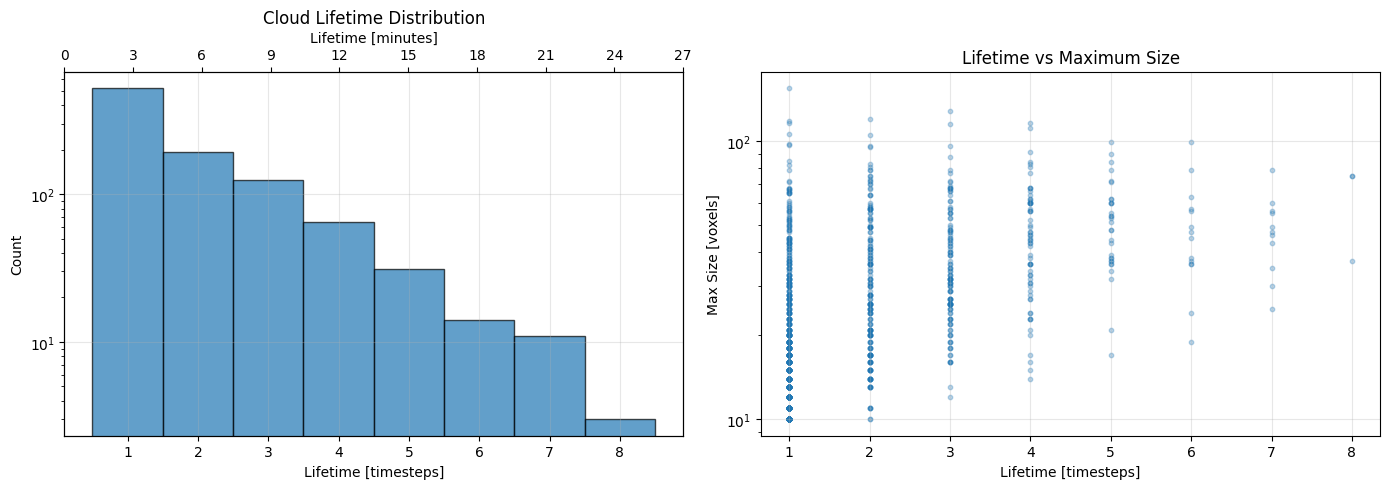

In [9]:
# Lifetime histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lifetime histogram
max_life = min(int(lifetimes.max()), 20)  # Cap at 20 for readability
bins = np.arange(0.5, max_life + 1.5, 1)
axes[0].hist(lifetimes, bins=bins, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Lifetime [timesteps]')
axes[0].set_ylabel('Count')
axes[0].set_title('Cloud Lifetime Distribution')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Add lifetime in minutes as secondary x-axis info
ax2 = axes[0].twiny()
ax2.set_xlim(axes[0].get_xlim())
ax2.set_xticks(axes[0].get_xticks())
ax2.set_xticklabels([f'{int(x * DT / 60)}' for x in axes[0].get_xticks()])
ax2.set_xlabel('Lifetime [minutes]')

# Lifetime vs max size scatter
axes[1].scatter(lifetimes, max_sizes, alpha=0.3, s=10)
axes[1].set_xlabel('Lifetime [timesteps]')
axes[1].set_ylabel('Max Size [voxels]')
axes[1].set_title('Lifetime vs Maximum Size')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Cloud Size Distribution

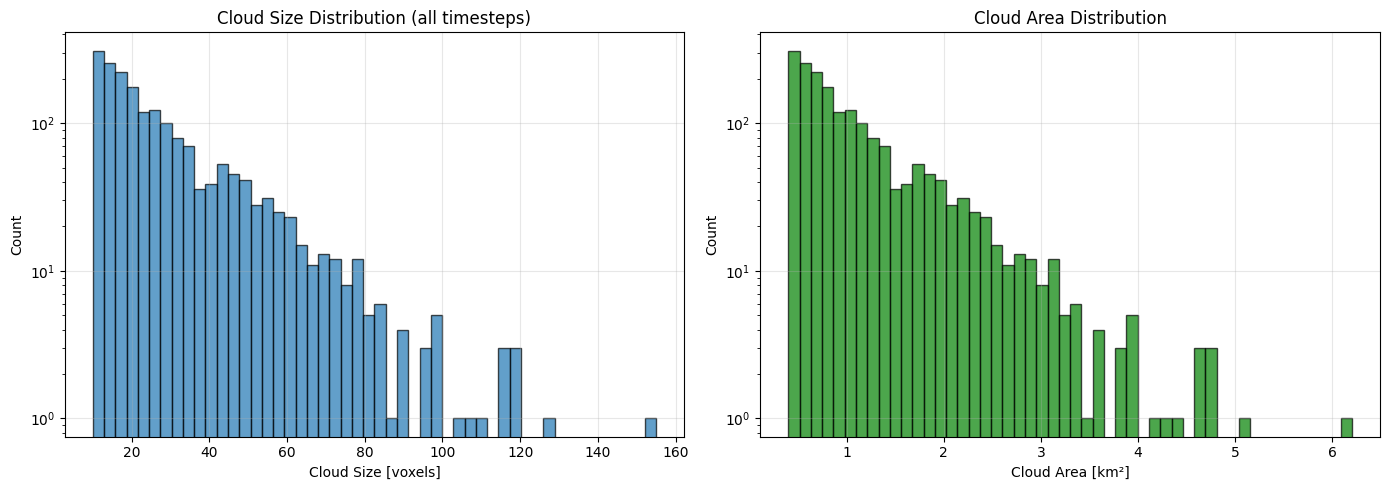

Size statistics (voxels):
  Min: 10
  Max: 155
  Mean: 27.5
  Median: 21.0


In [10]:
# Size distribution across all timesteps
all_sizes = size[np.isfinite(size) & (size > 0)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all cloud sizes
axes[0].hist(all_sizes, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cloud Size [voxels]')
axes[0].set_ylabel('Count')
axes[0].set_title('Cloud Size Distribution (all timesteps)')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Convert to area (km²)
areas_km2 = all_sizes * DX * DY / 1e6
axes[1].hist(areas_km2, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Cloud Area [km²]')
axes[1].set_ylabel('Count')
axes[1].set_title('Cloud Area Distribution')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Size statistics (voxels):")
print(f"  Min: {all_sizes.min():.0f}")
print(f"  Max: {all_sizes.max():.0f}")
print(f"  Mean: {all_sizes.mean():.1f}")
print(f"  Median: {np.median(all_sizes):.1f}")

## 5. Vertical Extent

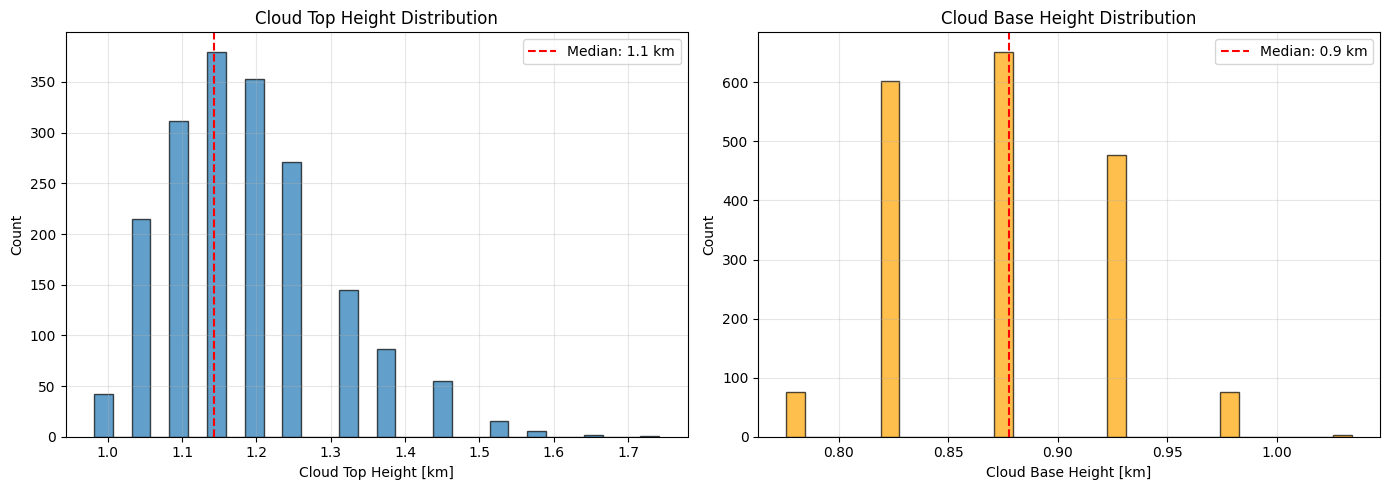

Cloud top heights: 1.0 - 1.7 km
Cloud base heights: 0.8 - 1.0 km


In [11]:
# Max height reached by clouds
max_height = ds['max_height'].values
cloud_base_height = ds['cloud_base_height'].values

# Get all valid max heights
all_max_heights = max_height[np.isfinite(max_height) & (max_height > 0)]
all_base_heights = cloud_base_height[np.isfinite(cloud_base_height) & (cloud_base_height > 0)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cloud top height distribution
axes[0].hist(all_max_heights / 1000, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cloud Top Height [km]')
axes[0].set_ylabel('Count')
axes[0].set_title('Cloud Top Height Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(np.median(all_max_heights) / 1000, color='r', linestyle='--', 
                label=f'Median: {np.median(all_max_heights)/1000:.1f} km')
axes[0].legend()

# Cloud base height distribution
axes[1].hist(all_base_heights / 1000, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Cloud Base Height [km]')
axes[1].set_ylabel('Count')
axes[1].set_title('Cloud Base Height Distribution')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(np.median(all_base_heights) / 1000, color='r', linestyle='--',
                label=f'Median: {np.median(all_base_heights)/1000:.1f} km')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Cloud top heights: {all_max_heights.min()/1000:.1f} - {all_max_heights.max()/1000:.1f} km")
print(f"Cloud base heights: {all_base_heights.min()/1000:.1f} - {all_base_heights.max()/1000:.1f} km")

## 6. Merge and Split Statistics

Do clouds merge and split? This is a key indicator of tracking working correctly.

Merge/Split Statistics:
  Tracks that merged at least once: 246
  Tracks that split at least once: 360
  Total merge events: 285
  Total split events: 387


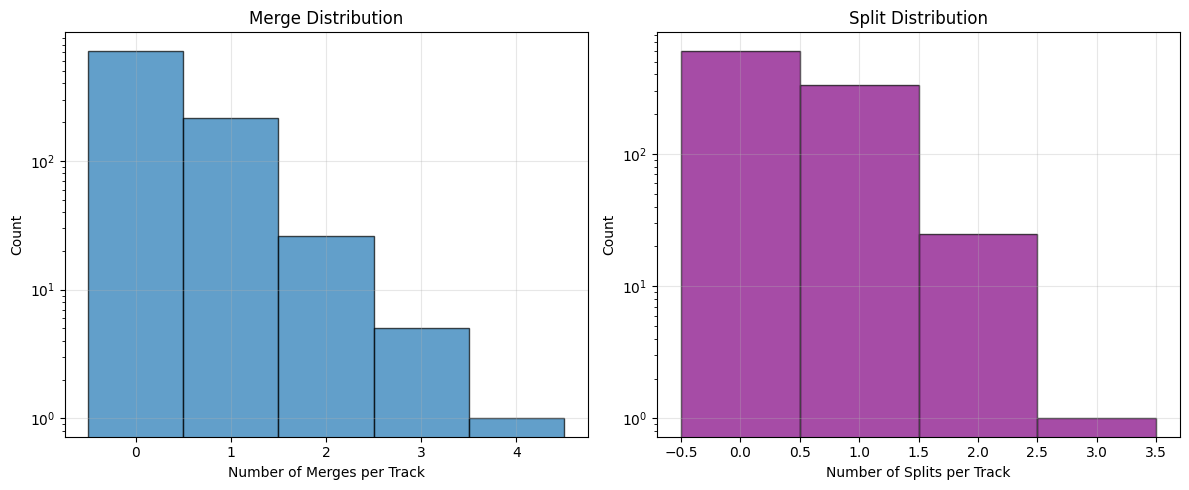

In [12]:
# Merge and split counts
merges_count = ds['merges_count'].values
splits_count = ds['splits_count'].values

# Total merges/splits per track
total_merges_per_track = np.nansum(merges_count, axis=1)
total_splits_per_track = np.nansum(splits_count, axis=1)

# Only consider tracks with data
tracks_with_data = has_data
merges_with_data = total_merges_per_track[tracks_with_data]
splits_with_data = total_splits_per_track[tracks_with_data]

print("Merge/Split Statistics:")
print(f"  Tracks that merged at least once: {np.sum(merges_with_data > 0)}")
print(f"  Tracks that split at least once: {np.sum(splits_with_data > 0)}")
print(f"  Total merge events: {int(np.nansum(merges_count))}")
print(f"  Total split events: {int(np.nansum(splits_count))}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Merge count distribution
merge_bins = np.arange(-0.5, min(10, merges_with_data.max()) + 1.5, 1)
axes[0].hist(merges_with_data, bins=merge_bins, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Merges per Track')
axes[0].set_ylabel('Count')
axes[0].set_title('Merge Distribution')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Split count distribution  
split_bins = np.arange(-0.5, min(10, max(1, splits_with_data.max())) + 1.5, 1)
axes[1].hist(splits_with_data, bins=split_bins, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Number of Splits per Track')
axes[1].set_ylabel('Count')
axes[1].set_title('Split Distribution')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Track Trajectory Visualization

Visualize the x-y positions of tracked clouds over time.

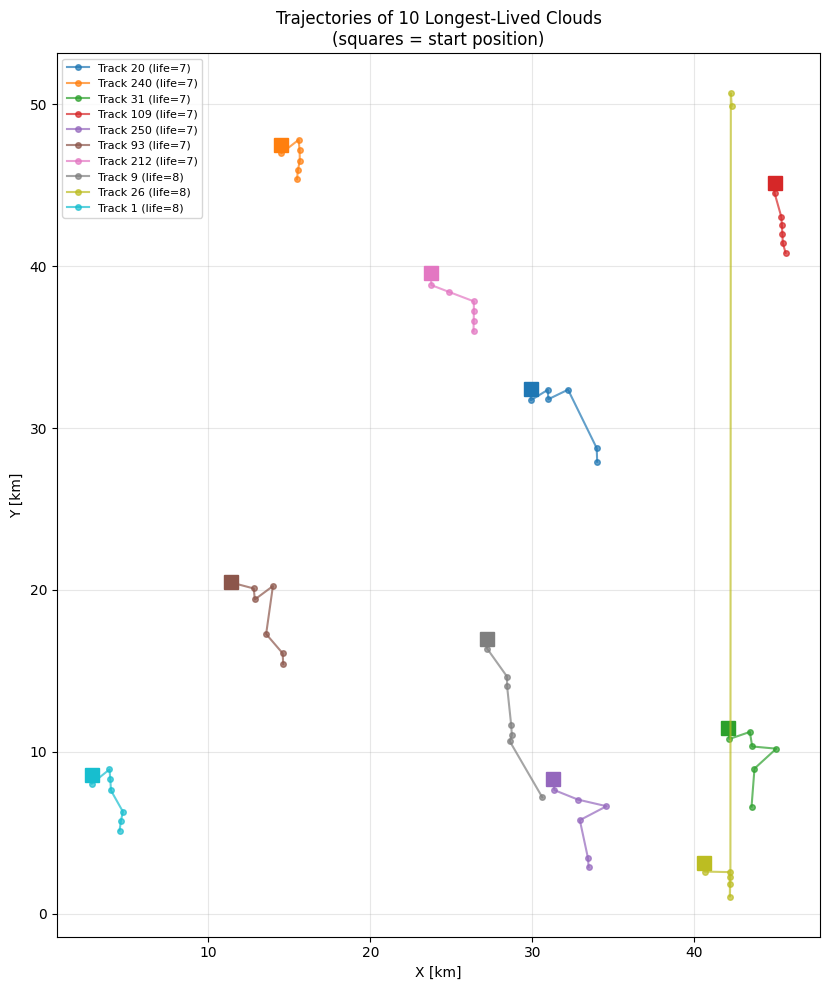

In [13]:
# Get cloud positions
loc_x = ds['location_x'].values
loc_y = ds['location_y'].values

# Find tracks with longest lifetimes for visualization
long_lived_idx = np.argsort(lifetimes)[-10:]  # Top 10 longest
actual_track_idx = track_indices[long_lived_idx]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot trajectories of long-lived clouds
colors = plt.cm.tab10(np.linspace(0, 1, len(actual_track_idx)))

for i, (tidx, color) in enumerate(zip(actual_track_idx, colors)):
    x = loc_x[tidx, :]
    y = loc_y[tidx, :]
    valid = np.isfinite(x) & np.isfinite(y)
    
    if np.sum(valid) > 1:
        ax.plot(x[valid] / 1000, y[valid] / 1000, 'o-', color=color, 
                markersize=4, linewidth=1.5, alpha=0.7,
                label=f'Track {tidx} (life={lifetimes[long_lived_idx[i]]})')
        # Mark start
        ax.plot(x[valid][0] / 1000, y[valid][0] / 1000, 's', color=color, markersize=10)

ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trajectories of 10 Longest-Lived Clouds\n(squares = start position)')
ax.set_aspect('equal')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Example: Single Cloud Lifecycle

Examine one tracked cloud in detail.

Example cloud: Track index 0, lifetime = 3 timesteps


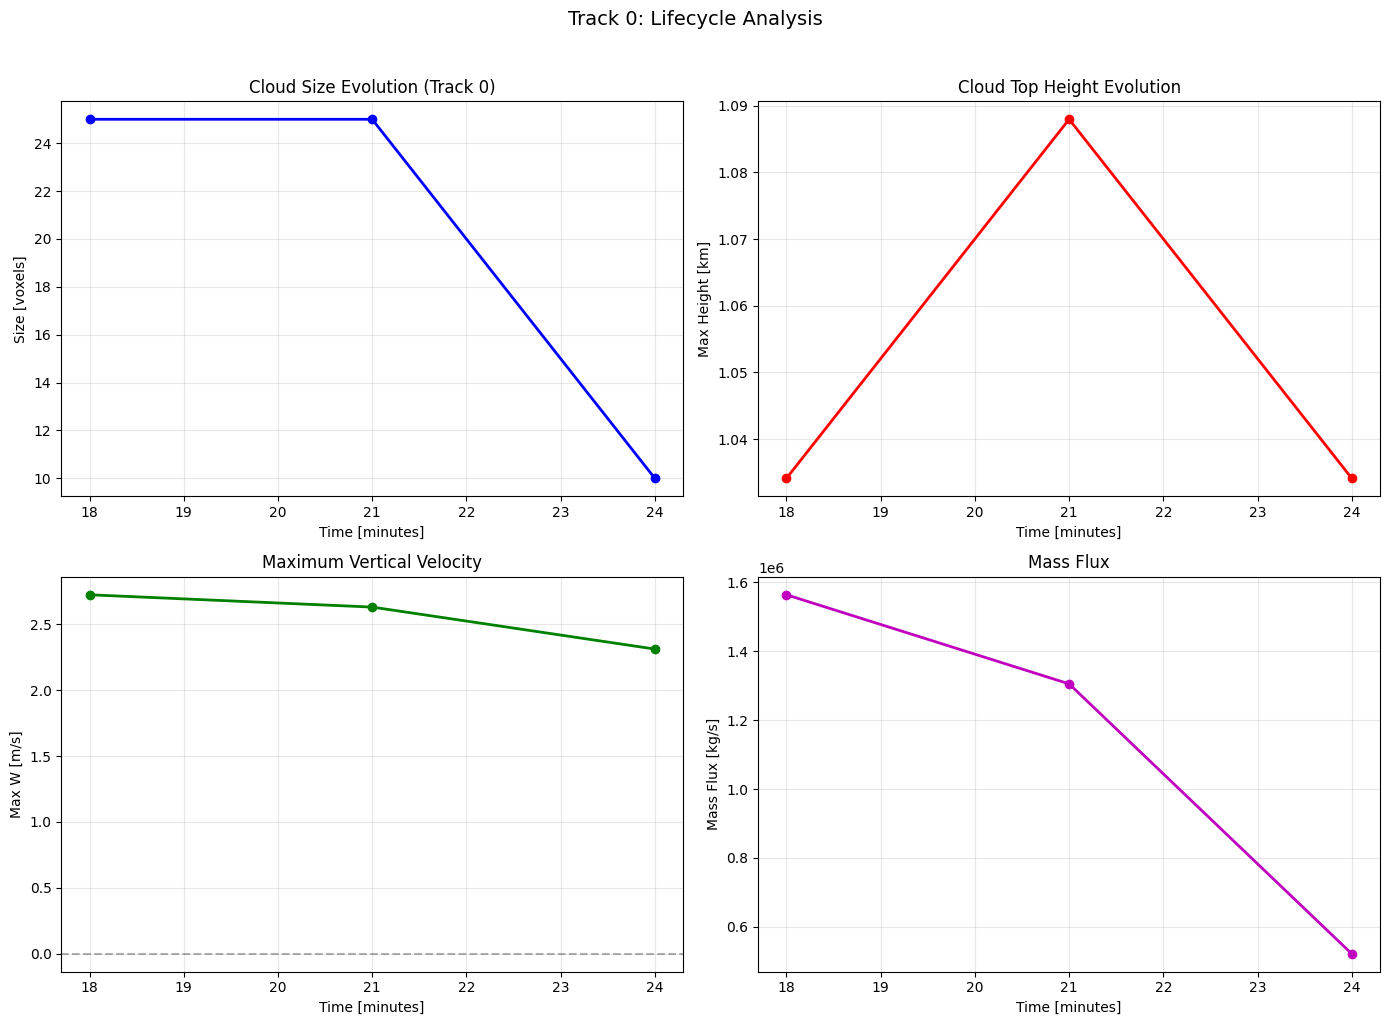


Merge events: 0
Split events: 0


In [14]:
# Pick a long-lived, valid cloud
valid_long = (lifetimes >= 3) & (valid_track[track_indices] == 1)
if np.sum(valid_long) > 0:
    example_idx = track_indices[valid_long][0]
    example_lifetime = lifetimes[valid_long][0]
else:
    # Fall back to longest track
    example_idx = track_indices[np.argmax(lifetimes)]
    example_lifetime = lifetimes.max()

print(f"Example cloud: Track index {example_idx}, lifetime = {example_lifetime} timesteps")

# Extract time series for this cloud
t_valid = np.where(np.isfinite(size[example_idx, :]) & (size[example_idx, :] > 0))[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Size evolution
ax = axes[0, 0]
ax.plot(t_valid * DT / 60, size[example_idx, t_valid], 'b-o', linewidth=2)
ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Size [voxels]')
ax.set_title(f'Cloud Size Evolution (Track {example_idx})')
ax.grid(True, alpha=0.3)

# Max height evolution
ax = axes[0, 1]
ax.plot(t_valid * DT / 60, max_height[example_idx, t_valid] / 1000, 'r-o', linewidth=2)
ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Max Height [km]')
ax.set_title('Cloud Top Height Evolution')
ax.grid(True, alpha=0.3)

# Max vertical velocity
max_w = ds['max_w'].values
ax = axes[1, 0]
ax.plot(t_valid * DT / 60, max_w[example_idx, t_valid], 'g-o', linewidth=2)
ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Max W [m/s]')
ax.set_title('Maximum Vertical Velocity')
ax.axhline(0, color='k', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3)

# Mass flux
mass_flux = ds['mass_flux'].values
ax = axes[1, 1]
ax.plot(t_valid * DT / 60, mass_flux[example_idx, t_valid], 'm-o', linewidth=2)
ax.set_xlabel('Time [minutes]')
ax.set_ylabel('Mass Flux [kg/s]')
ax.set_title('Mass Flux')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Track {example_idx}: Lifecycle Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Check for merges/splits
track_merges = np.nansum(merges_count[example_idx, :])
track_splits = np.nansum(splits_count[example_idx, :])
print(f"\nMerge events: {int(track_merges)}")
print(f"Split events: {int(track_splits)}")

## 9. Summary Statistics

In [15]:
print("=" * 60)
print("LBA TRACKING VALIDATION SUMMARY")
print("=" * 60)

print(f"\n1. DATASET:")
print(f"   Timesteps processed: {n_times}")
print(f"   Time span: {n_times * DT / 60:.1f} minutes")

print(f"\n2. TRACKING RESULTS:")
print(f"   Total tracks created: {n_with_data}")
print(f"   Valid (complete lifecycle): {n_valid} ({100*n_valid/max(1,n_with_data):.1f}%)")
print(f"   Tainted (partial lifecycle): {n_tainted}")

print(f"\n3. CLOUD CONTINUITY:")
print(f"   Single-timestep clouds: {single_timestep} ({100*single_timestep/len(lifetimes):.1f}%)")
print(f"   Multi-timestep clouds: {multi_timestep} ({100*multi_timestep/len(lifetimes):.1f}%)")
print(f"   Max lifetime: {lifetimes.max()} timesteps ({lifetimes.max() * DT / 60:.1f} min)")

print(f"\n4. CLOUD INTERACTIONS:")
print(f"   Total merge events: {int(np.nansum(merges_count))}")
print(f"   Total split events: {int(np.nansum(splits_count))}")

print(f"\n5. CLOUD SIZES:")
print(f"   Size range: {all_sizes.min():.0f} - {all_sizes.max():.0f} voxels")
print(f"   Mean size: {all_sizes.mean():.1f} voxels")

print(f"\n6. VERTICAL EXTENT:")
print(f"   Cloud base range: {all_base_heights.min()/1000:.1f} - {all_base_heights.max()/1000:.1f} km")
print(f"   Cloud top range: {all_max_heights.min()/1000:.1f} - {all_max_heights.max()/1000:.1f} km")

# Overall assessment
print("\n" + "=" * 60)
if multi_timestep > 0 and lifetimes.max() > 2:
    print("✓ TRACKING APPEARS TO BE WORKING:")
    print("  - Clouds are being tracked across multiple timesteps")
    print("  - Merge/split events are being detected")
else:
    print("⚠ POTENTIAL ISSUES:")
    if multi_timestep == 0:
        print("  - No clouds tracked across timesteps - check matching parameters")
    if lifetimes.max() <= 2:
        print("  - Very short lifetimes - may need more timesteps or parameter tuning")

LBA TRACKING VALIDATION SUMMARY

1. DATASET:
   Timesteps processed: 15
   Time span: 45.0 minutes

2. TRACKING RESULTS:
   Total tracks created: 965
   Valid (complete lifecycle): 99729 (10334.6%)
   Tainted (partial lifecycle): 271

3. CLOUD CONTINUITY:
   Single-timestep clouds: 522 (54.1%)
   Multi-timestep clouds: 443 (45.9%)
   Max lifetime: 8 timesteps (24.0 min)

4. CLOUD INTERACTIONS:
   Total merge events: 285
   Total split events: 387

5. CLOUD SIZES:
   Size range: 10 - 155 voxels
   Mean size: 27.5 voxels

6. VERTICAL EXTENT:
   Cloud base range: 0.8 - 1.0 km
   Cloud top range: 1.0 - 1.7 km

✓ TRACKING APPEARS TO BE WORKING:
  - Clouds are being tracked across multiple timesteps
  - Merge/split events are being detected


In [16]:
# Close dataset
ds.close()

## 10. Cloud Volume and Birth/Death Time Series

Track cloud population dynamics: volumes (valid/tainted), births (true vs from splits), deaths, and survivors over time.

In [17]:
def compute_cloud_time_series_stable_births(
    nc_path,
    size_min=0,            # exclude clouds smaller than this from counts AND volumes
    min_survival=3,        # require births to survive at least this many steps
    counts_valid_only=True # restrict counts to valid (complete lifecycle) tracks
):
    """Compute cloud volume and birth/death time series with survival filtering."""
    with Dataset(nc_path, 'r') as ds:
        size = np.asarray(np.ma.filled(ds.variables['size'][:], np.nan), dtype=float)  # (track,time)
        n_tracks, n_time = size.shape
        valid_mask = (np.asarray(ds.variables['valid_track'][:]) == 1)                # (track,)
        split_from = ds.variables.get('split_from')
        split = (np.asarray(np.ma.filled(split_from[:], -1), dtype=int)
                 if split_from is not None else np.full_like(size, -1, dtype=int))

        # Threshold by size for both counts and volumes
        size_thr = size.copy()
        if size_min > 0:
            size_thr[size_thr < size_min] = np.nan

        # Volumes (valid, tainted, total)
        volume_total   = np.nansum(size_thr, axis=0)
        volume_valid   = np.nansum(np.where(valid_mask[:, None], size_thr, np.nan), axis=0)
        volume_tainted = np.nansum(np.where(~valid_mask[:, None], size_thr, np.nan), axis=0)

        # Counts base array (optionally restrict to valid tracks)
        size_cnt = size_thr.copy()
        if counts_valid_only:
            size_cnt[~valid_mask, :] = np.nan

        alive = np.isfinite(size_cnt)                    # (track,time) bool
        alive_count = alive.sum(axis=0).astype(int)

        # Birth/death/survivor primitives
        births_raw = np.zeros_like(alive, dtype=bool)
        births_raw[:, 0] = alive[:, 0]
        if n_time > 1:
            births_raw[:, 1:] = alive[:, 1:] & ~alive[:, :-1]

        alive_prev = np.zeros_like(alive, dtype=bool)
        alive_prev[:, 1:] = alive[:, :-1]
        deaths     = (alive_prev & ~alive).sum(axis=0).astype(int)
        survivors  = (alive_prev &  alive).sum(axis=0).astype(int)

        # Survival length from each timestep (consecutive alive run length)
        survival_len = np.zeros_like(alive, dtype=int)
        for t in range(n_time - 1, -1, -1):
            if t == n_time - 1:
                survival_len[:, t] = alive[:, t].astype(int)
            else:
                survival_len[:, t] = np.where(alive[:, t], 1 + survival_len[:, t + 1], 0)

        births_survive = births_raw & (survival_len >= int(min_survival))

        # Classify births (true vs from splits), after survival filter
        split_mask = (split >= 0)
        births_from_splits_surv = (births_survive & split_mask).sum(axis=0).astype(int)
        births_true_surv        = (births_survive & ~split_mask).sum(axis=0).astype(int)
        births_total_surv       = births_true_surv + births_from_splits_surv

    return dict(
        # volumes
        volume_valid=volume_valid,
        volume_tainted=volume_tainted,
        volume_total=volume_total,
        # counts
        alive=alive_count,
        deaths=deaths,
        survivors=survivors,
        births_true=births_true_surv,
        births_from_splits=births_from_splits_surv,
        births_total=births_total_surv
    )

In [18]:
def plot_cloud_time_series_stable_births(series, dt_seconds=DT, title_suffix=""):
    """Plot cloud volume and birth/death time series."""
    n_time = series['alive'].size
    t = np.arange(n_time)
    t_min = t * dt_seconds / 60  # Convert to minutes
    
    fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

    # Top: volumes
    axes[0].plot(t_min, series['volume_valid'],   lw=2, label='Volume (valid)')
    axes[0].plot(t_min, series['volume_tainted'], lw=2, label='Volume (tainted)')
    axes[0].plot(t_min, series['volume_total'],   lw=2, color='k', label='Volume (total)')
    axes[0].set_ylabel('Total volume [voxels]')
    axes[0].set_title(f'LBA Cloud Volume and Counts Over Time {title_suffix}')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(ncol=3, loc='upper right')

    # Bottom: counts with survival-filtered births
    axes[1].plot(t_min, series['alive'],      lw=2, label='Alive', color='tab:gray')
    axes[1].plot(t_min, series['deaths'],     lw=1.8, label='Deaths', color='tab:red')
    axes[1].plot(t_min, series['survivors'],  lw=1.8, label='Survivors', color='tab:orange')
    axes[1].plot(t_min, series['births_true'],        lw=2, label='Births (true)', color='tab:green')
    axes[1].plot(t_min, series['births_from_splits'], lw=2, label='Births (from splits)', color='tab:blue')
    axes[1].plot(t_min, series['births_total'],       lw=1.2, ls='--', color='k', alpha=0.6, label='Births (total)')

    axes[1].set_xlabel('Time [minutes]')
    axes[1].set_ylabel('Count')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(ncol=3, loc='upper right')

    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTime Series Summary:")
    print(f"  Total timesteps: {n_time}")
    print(f"  Mean alive (valid): {series['alive'].mean():.1f}")
    print(f"  Total births (true): {series['births_true'].sum()}")
    print(f"  Total births (from splits): {series['births_from_splits'].sum()}")
    print(f"  Total deaths: {series['deaths'].sum()}")

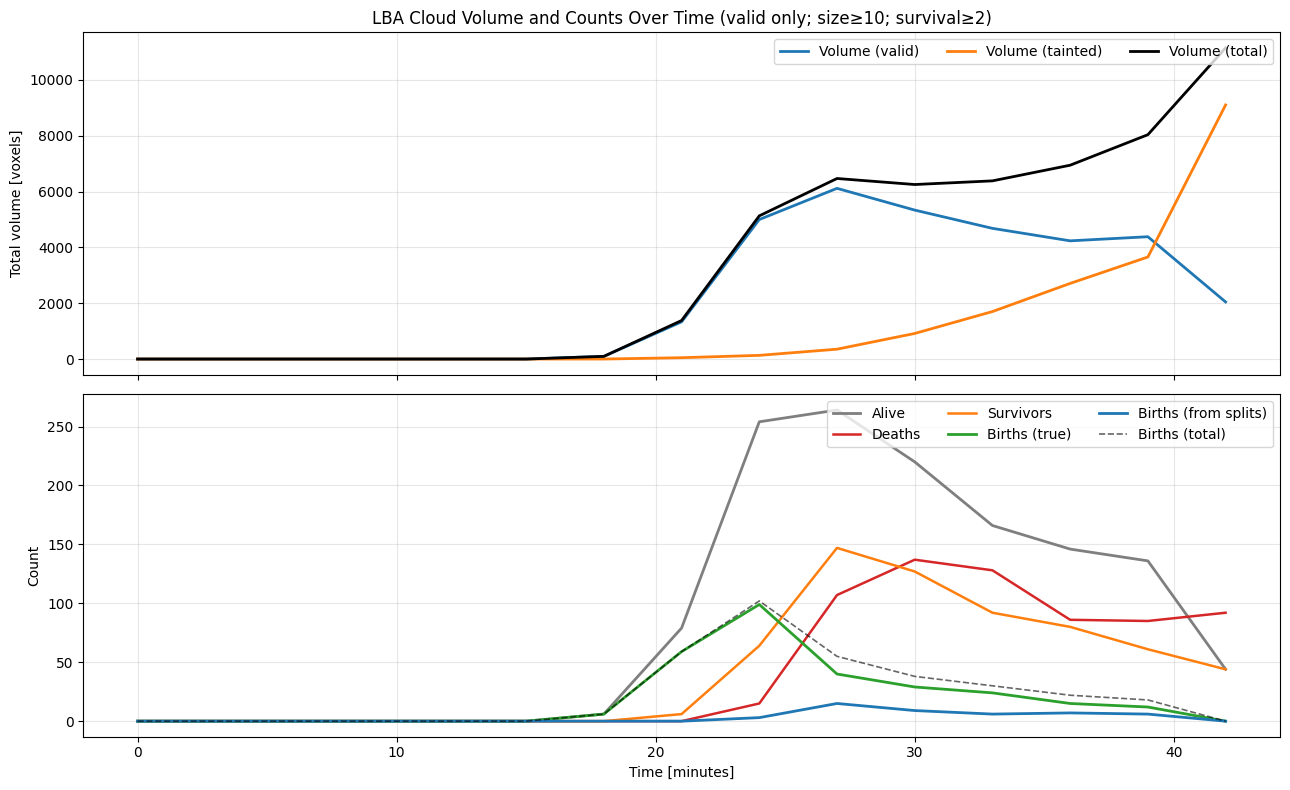


Time Series Summary:
  Total timesteps: 15
  Mean alive (valid): 87.7
  Total births (true): 284
  Total births (from splits): 46
  Total deaths: 650


In [19]:
# Compute and plot cloud time series
# Parameters:
#   size_min: exclude clouds smaller than this (voxels)
#   min_survival: require births to survive at least this many timesteps
#   counts_valid_only: only count valid (complete lifecycle) tracks

series = compute_cloud_time_series_stable_births(
    NC_FILE,
    size_min=10,           # Minimum cloud size (voxels)
    min_survival=2,        # Require 2+ consecutive timesteps after birth
    counts_valid_only=True # Only count valid tracks
)

plot_cloud_time_series_stable_births(
    series, 
    dt_seconds=DT,
    title_suffix=f"(valid only; size≥10; survival≥2)"
)